<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - Previsión de demanda mediante uso de técnicas de machine learning
</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Carlos Pérez Cebrián</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Impacto económico

Se quiere estudiar el impacto económico que supone la aplicación del modelo que mejor resultados ha obtenido en la predicción de ventas.
Para ello, utilizaremos el modelo XGBoost (Extreme Gradient Boosting) y el conjunto de datos Ventas y Precio Medio

Cargamos las siguientes librerías necesarias:

In [1]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import cluster        # algoritmos de clustering.
from sklearn import datasets       
from sklearn.preprocessing import StandardScaler #estandarizar datos
from sklearn.decomposition import PCA #análisis de componentes principales, reducir dimensiones
from sklearn.preprocessing import LabelEncoder #codificación variables categóricas
from sklearn.model_selection import train_test_split  #split dataframes train, test, validación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #metricas
import xgboost as xgb
from xgboost import XGBRegressor   # Importar la clase XGBClassifier
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Cargar el modelo XGBoost desde el archivo JSON
modelo_xgb = xgb.Booster()
modelo_xgb.load_model('modelo_xgboost.json')

# características del modelo
variables_modelo = modelo_xgb.feature_names
print("Variables utilizadas en el modelo:", variables_modelo)

Variables utilizadas en el modelo: ['producto', 'bolOpen', 'EnPromocion', 'diasemana', 'semana', 'media_7_dias', 'media_30_dias', 'venta_lag_1', 'venta_lag_7', 'venta_lag_30']


Cargar el conjunto de datos:
(Nota: el conjunto de datos es el resultado de una fase de exploración, analisis y preparación previa.

In [3]:
# Cargar el archivo CSV con los datos de ventas
file_path = "Data/VentasRdo.csv"
#file_path = "Data/VentasRdo_10productos.csv"
dfVenta = pd.read_csv(file_path, parse_dates=['idSecuencia'])

# Cargar el archivo CSV con los precios medios de cada producto
file_path = "Data/DatosPrecioMedio.xlsx"
dfPrecioMedio = pd.read_excel(file_path)

# Ciclo de aprovisionamiento
file_path = "Data/DatosCicloAprovisionamiento.xlsx"
dfCicloAprovisionamiento = pd.read_excel(file_path)

In [4]:
# mismas variables
dfVenta_prediccion = dfVenta[variables_modelo].copy()  

# Codificar variables categóricas
label_encoder = LabelEncoder()
dfVenta_prediccion['producto'] = label_encoder.fit_transform(dfVenta_prediccion['producto'])
dfVenta_prediccion['bolOpen'] = label_encoder.fit_transform(dfVenta_prediccion['bolOpen'])
dfVenta_prediccion['EnPromocion'] = label_encoder.fit_transform(dfVenta_prediccion['EnPromocion'])
dfVenta_prediccion['diasemana'] = label_encoder.fit_transform(dfVenta_prediccion['diasemana'])
dfVenta_prediccion['semana'] = label_encoder.fit_transform(dfVenta_prediccion['semana'])

# revisar columnas en dfVenta_prediccion y del modelo
dfVenta_prediccion = dfVenta_prediccion[variables_modelo]

#matriz numpy(formato XGBoost)
X_pred = xgb.DMatrix(dfVenta_prediccion)

In [5]:
# predecir
predicciones = modelo_xgb.predict(X_pred)

# añadir las predicciones
# las predicciones están en escala logaritmica por el problema de la heterostacidad.
dfVenta['predicciones_udsVenta'] = np.exp(predicciones)
# las unidades están en escala logaritmica porque hemos cargado el fichero de la preparación
dfVenta['udsVenta_original'] = np.exp(dfVenta['udsVenta'])

In [6]:
# combinar ventas con dfPrecioMedio
dfResultado = dfVenta.merge(dfPrecioMedio, on='producto')

Comparar coste (actual vs estimado)

In [7]:
# Calcular el coste con la unidades actuales y estimadas
dfResultado['importe_prediccion'] = dfResultado['predicciones_udsVenta'] * dfResultado['eurPrecioMedio']
dfResultado['importe_actual'] = dfResultado['udsVenta_original'] * dfResultado['eurPrecioMedio']

# diferencia entre los importes
dfResultado['mejora_economica'] = dfResultado['importe_prediccion'] - dfResultado['importe_actual']

mejora_total = dfResultado['mejora_economica'].sum()
print(f"Mejora económica total: {mejora_total}")

Mejora económica total: -7767713.559337854


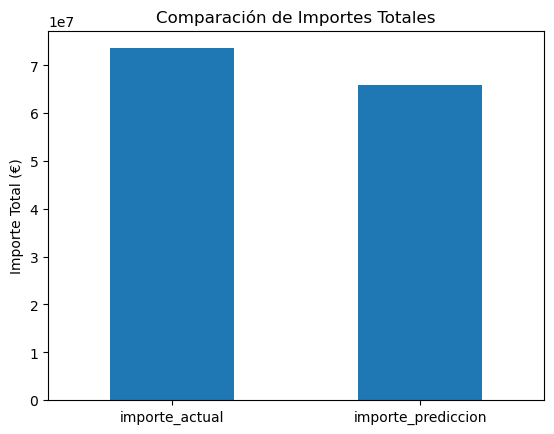

In [8]:
# Graficar los resultados
dfResultado[['importe_actual', 'importe_prediccion']].sum().plot(kind='bar',
                                                                title='Comparación de Importes Totales',
                                                                ylabel='Importe Total (€)',
                                                                rot=0)
plt.show()

Calcular stock de seguridad.

El stock de seguridad es el inventario que se tiene en el almacén para hacer frente a imprevistos relacionados con cambios en la demanda o retrasos de los proveedores, así evitar posibles roturas de stock.

Lo calculamos de la siguiente forma:

Stock de seguridad = Factor servicio * RMSE * raíz del ciclo de aprovisionamiento

Es decir, que cuanto menor RMSE proporcione nuestro algoritmo, menor stock de seguridad necesitaremos y por tanto menor cantidad de mercancía tendremos que tener almacenada (con el ahorro en costes que ello supone).


In [9]:
# Calcular el stock de seguridad
def calcular_stock_seguridad(rmse, dias_entre_pedidos, dias_leadtime):
    dias_aprovisionamiento = dias_entre_pedidos + dias_leadtime
    return factor_servicio * rmse * np.sqrt(dias_aprovisionamiento)


El Factor servicio se calcula como la distribución normal estándar inversa para una probabilidad dada.
El factor servicio de un nivel de servicio de 95% =1.64. (Lo puedes comprobar tú mismo en la excel con la función =DISTR.NORM.ESTAND.INV(0.95).

In [10]:
# Configuración del nivel de servicio
nivel_servicio = 0.95
factor_servicio = norm.ppf(nivel_servicio)

In [11]:
# Calcular el RMSE
def calcular_rmse(real, pred):
    return np.sqrt(np.mean((real - pred) ** 2))

Comparamos dos escenarios: la previsión de referencia con un método naive (media) y la previsión obtenida con el modelo XGBoost

Primero adjuntamos la información de ciclos de aprovisonamiento, después se calcula la desviación estándar de la demanda para cada escenario y por último se calcula el stock de seguridad en función a RMSE y el ciclo de aprovisionamiento.

In [12]:
# Unir dfResultado con dfCicloAprovisionamiento
dfResultado = pd.merge(dfResultado, dfCicloAprovisionamiento, on='producto')

In [13]:
# Naive - predicción: media de las ventas reales y calculo de desviación (rmse)
dfResultado['pred_naive'] = dfResultado['udsVenta_original'].mean()
rmse_naive = calcular_rmse(dfResultado['udsVenta_original'], dfResultado['pred_naive'])

print(f"Naive - RMSE: {rmse_naive:.2f}")

Naive - RMSE: 2.30


In [14]:
# Naive - Calcular stock de seguridad
dfResultado['stock_seguridad_naive'] = calcular_stock_seguridad(
    rmse_naive, dfResultado['diasEntrePedidos'], dfResultado['diasLeadtime']
)

In [15]:
# XGBoost - calculo de desviación (rmse)
rmse_modelo = calcular_rmse(dfResultado['udsVenta_original'], dfResultado['predicciones_udsVenta'])
print(f"XGBoost - RMSE: {rmse_modelo:.2f}")

XGBoost - RMSE: 1.79


In [16]:
# XGBoost - Calcular stock de seguridad
dfResultado['stock_seguridad_modelo'] = calcular_stock_seguridad(
    rmse_modelo, dfResultado['diasEntrePedidos'], dfResultado['diasLeadtime']
)

Coste unitario asociado al stock = Coste de almacenaje + Coste de oportunidad de la inversión, donde:

   _Coste de almacenaje_: Coste asociado principalmente al alquiler y manutención de naves de almacén, y a las operaciones en el almacén. 

   _Coste de oportunidad de la inversión_: Coste financiero debido al importe que "dejamos de ganar" al tener el dinero invertido en stock, pudiendo tenerlo invertido en un producto financiero, en nuevos procesos de planta que reportarían beneficio, etc.

Podemos estimar el coste de stock como sigue:

  _Coste stock de un día en stock  = % Coste unitario * valor de las unidades en stock =  (5% * (precio * Unidades en stock)_


In [17]:
# Calcular el coste del stock
def calcular_coste_stock(stock, precio_unitario):
    return 0.05 * precio_unitario * stock

In [18]:
# Naive - Coste del stock de seguridad
dfResultado['coste_stock_naive'] = calcular_coste_stock(dfResultado['stock_seguridad_naive'], dfResultado['eurPrecioMedio'])

In [19]:
# XGBoost - Coste del stock de seguridad
dfResultado['coste_stock_modelo'] = calcular_coste_stock(dfResultado['stock_seguridad_modelo'], dfResultado['eurPrecioMedio'])

In [20]:
# Coste asociado al stock de seguridad 
coste_total_naive = dfResultado['coste_stock_naive'].sum()
coste_total_modelo = dfResultado['coste_stock_modelo'].sum()

print(f"Naive   - Coste asociado al stock de seguridad: {coste_total_naive:.2f}")
print(f"XGBoost - Coste asociado al stock de seguridad: {coste_total_modelo:.2f}")

Naive   - Coste asociado al stock de seguridad: 26046173.41
XGBoost - Coste asociado al stock de seguridad: 20308837.28


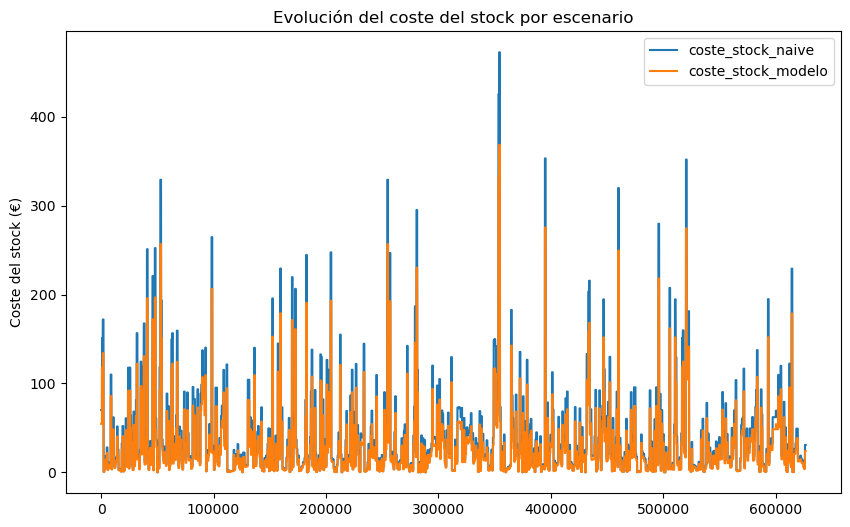

In [21]:
# Gráfica con los resultados
dfResultado[['coste_stock_naive', 'coste_stock_modelo']].plot(
    figsize=(10, 6), title="Evolución del coste del stock por escenario")
plt.ylabel("Coste del stock (€)")
plt.show()

Conclusiones:

El RMSE más alto del escenario Naive indica una mayor incertidumbre en la demanda, lo que genera una necesidad de stock de seguridad más elevado y, por lo tanto, un coste significativamente mayor.

La diferencia en los costes, 5,737,336.13 €, demuestra un impacto económico positivo de utilizar un modelo de predicción más preciso; que refleja no solo una mejora en la eficiencia del inventario, sino también una optimización de recursos financieros y operativos.
